In this section you will do a practical application of GPU-accelerated data analysis using the RAPIDS
suite of libraries. The focus will be on leveraging the New York City Taxi Trip Duration dataset from
Kaggle, applying Gradient Boosting Machine (GBM) models for predictive analysis, with a particular
emphasis on comparing the speed and efficiency of GPU-accelerated computations with traditional CPUbased methods 

1. Comparative Data Processing
(a)  Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the
same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.
(b)  Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib)
and GPU-accelerated tools, noting any differences in performance and responsiveness.
2. Feature Engineering and Selection
(a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.
(b) Select relevant features for the model based on their correlation with the target variable,
assessing the speed of these operations on CPU and GPU.
3. Model Training and Evaluation
(a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU)
and cuML (GPU). Record and compare the training times.
(b) Evaluate the accuracy of both models and document the time taken for predictions on the
test set using CPU and GPU.
4. Performance Analysis
(a) Compile and compare the execution times for tasks performed on CPU vs. GPU, creating a
detailed analysis of the observed performance differences.
(b) Reflect on the implications of these findings for data science workflows, particularly in terms
of efficiency and scalability.

# (a) Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.

In [ ]:
#!pip install pandas==1.5.3
#!pip install matplotlib
#!pip install geopandas
#!pip install contextily
#!pip install osmnx==1.1.1 shapely==1.7.1

In [ ]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.2.* dask-cudf-cu12==24.2.* cuml-cu12==24.2.* \
#     cugraph-cu12==24.2.* cuspatial-cu12==24.2.* cuproj-cu12==24.2.* \
#     cuxfilter-cu12==24.2.* cucim-cu12==24.2.* pylibraft-cu12==24.2.* \
#     raft-dask-cu12==24.2.*

In [79]:
# Importing necessary libraries
import pandas as pd
import cudf
import cupy as cp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import haversine as hs   
from haversine import Unit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import osmnx as ox
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd
import contextily as ctx

## Loading the Datasts

In [80]:
# create a dataframe to hold CPU Metrics
cpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

# create a dataframe to hold GPU Metrics
gpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

In [81]:
# Load the data using cuDF
start_time_gpu = time.time()
sample_submission_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_gpu = time.time()

In [82]:
# Load the data using pandas
start_time_cpu = time.time()
sample_submission_cpu = pd.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_cpu = pd.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_cpu = pd.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_cpu = time.time()

In [85]:
# Display the time taken for data loading using pandas
print("Time taken for data loading using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for data loading using cuDF
print("Time taken for data loading using GUP: ", end_time_gpu - start_time_gpu)

Time taken for data loading using pandas:  5.761559724807739
Time taken for data loading using GUP:  0.2771492004394531


In [86]:
# Add the metrics to the dataframe
cpu_metrics.loc[0] = ['Data Loading', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[0] = ['Data Loading', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [87]:
sample_submission_cpu.head(5)

id  trip_duration
0  id3004672            959
1  id3505355            959
2  id1217141            959
3  id2150126            959
4  id1598245            959

In [88]:
test_cpu.head(5)

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

In [89]:
train_cpu.head(5)

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

## Data Preprocessing


In [90]:
# Data Preprocessing using cuDF
time_start_gpu = time.time()
# drop rows with missing values
train_gpu.dropna(inplace=True)
test_gpu.dropna(inplace=True)

# drop records with duplicated IDs
train_gpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_gpu['pickup_datetime'] = cudf.to_datetime(train_gpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_gpu.drop('dropoff_datetime', axis=1, inplace=True)

test_gpu['pickup_datetime'] = cudf.to_datetime(test_gpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_gpu['pickup_month'] = train_gpu['pickup_datetime'].dt.month
train_gpu['pickup_day'] = train_gpu['pickup_datetime'].dt.dayofweek
train_gpu['pickup_hour'] = train_gpu['pickup_datetime'].dt.hour

test_gpu['pickup_month'] = test_gpu['pickup_datetime'].dt.month
test_gpu['pickup_day'] = test_gpu['pickup_datetime'].dt.dayofweek
test_gpu['pickup_hour'] = test_gpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column 
train_gpu.drop('store_and_fwd_flag', axis=1, inplace=True)

#  drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_gpu.drop('pickup_datetime', axis=1, inplace=True)
test_gpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_gpu.drop('id', axis=1, inplace=True)
test_gpu.drop('id', axis=1, inplace=True)

end_time_gpu = time.time()

In [91]:
# Data Preprocessing using pandas
time_start_cpu = time.time()
# drop rows with missing values
train_cpu.dropna(inplace=True)
test_cpu.dropna(inplace=True)

# drop records with duplicated IDs
train_cpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_cpu['pickup_datetime'] = pd.to_datetime(train_cpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_cpu.drop('dropoff_datetime', axis=1, inplace=True)

test_cpu['pickup_datetime'] = pd.to_datetime(test_cpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_cpu['pickup_month'] = train_cpu['pickup_datetime'].dt.month
train_cpu['pickup_day'] = train_cpu['pickup_datetime'].dt.dayofweek
train_cpu['pickup_hour'] = train_cpu['pickup_datetime'].dt.hour

test_cpu['pickup_month'] = test_cpu['pickup_datetime'].dt.month
test_cpu['pickup_day'] = test_cpu['pickup_datetime'].dt.dayofweek
test_cpu['pickup_hour'] = test_cpu['pickup_datetime'].dt.hour

# drop the store_and_fwd_flag column
train_cpu.drop('store_and_fwd_flag', axis=1, inplace=True)

# drop the 'pickup_datetime' column since we have extracted the month, day, and hour
train_cpu.drop('pickup_datetime', axis=1, inplace=True)
test_cpu.drop('pickup_datetime', axis=1, inplace=True)

# drop the 'id' column since it is not needed for prediction
train_cpu.drop('id', axis=1, inplace=True)
test_cpu.drop('id', axis=1, inplace=True)

end_time_cpu = time.time()

In [92]:
# Display the time taken for data preprocessing using pandas
print("Time taken for data preprocessing using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for data preprocessing using cuDF
print("Time taken for data preprocessing using GUP: ", end_time_gpu - time_start_gpu)

Time taken for data preprocessing using pandas:  4.507148504257202
Time taken for data preprocessing using GUP:  0.06368207931518555


In [93]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Data Preprocessing', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Data Preprocessing', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [94]:
# make the trip duration the last column in the train dataset
train_gpu = train_gpu[[col for col in train_gpu.columns if col != 'trip_duration'] + ['trip_duration']]
train_cpu = train_cpu[[col for col in train_cpu.columns if col != 'trip_duration'] + ['trip_duration']]

In [95]:
train_cpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude  pickup_month  pickup_day  pickup_hour  \
0         -73.964630         40.765602             3           0           17   
1         -73.999481         40.731152             6           6            0   
2         -74.005333         40.710087             1           1           11   
3         -74.012268         40.706718             4           2           19   
4         -73.972923         40.782520             3           5           13   

   trip_duration  
0            455  
1            663  
2           2124  
3            429  
4            435

In [96]:
test_cpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  pickup_month  \
0         -73.990173         40.756680                  N             6   
1         -73.959808         40.655403                  N             6   
2         -73.986160         40.729523                  N             6   
3         -73.986427         40.730469                  N             6   
4         -73.961510         40.755890                  N             6   

   pickup_day  pickup_hour  
0           3           23  
1           3           23  
2           3           23  
3           3           23  
4           3           23

In [97]:
train_gpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude  pickup_month  pickup_day  pickup_hour  \
0         -73.964630         40.765602             3           0           17   
1         -73.999481         40.731152             6           6            0   
2         -74.005333         40.710087             1           1           11   
3         -74.012268         40.706718             4           2           19   
4         -73.972923         40.782520             3           5           13   

   trip_duration  
0            455  
1            663  
2           2124  
3            429  
4            435

In [98]:
test_gpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  pickup_month  \
0         -73.990173         40.756680                  N             6   
1         -73.959808         40.655403                  N             6   
2         -73.986160         40.729523                  N             6   
3         -73.986427         40.730469                  N             6   
4         -73.961510         40.755890                  N             6   

   pickup_day  pickup_hour  
0           3           23  
1           3           23  
2           3           23  
3           3           23  
4           3           23

## Outlier Analysis

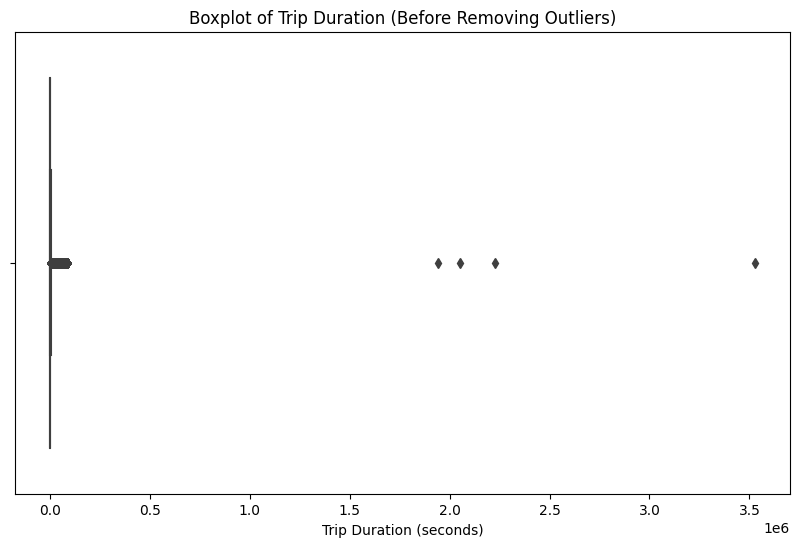


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



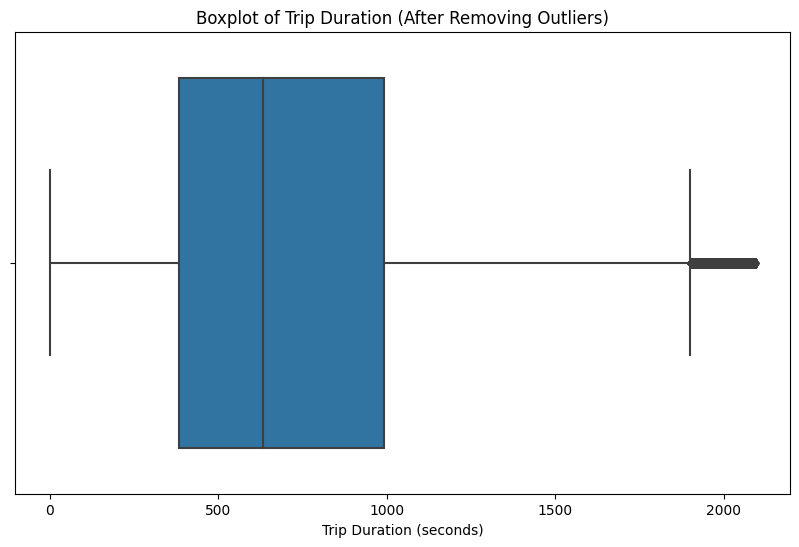

In [99]:
# Using CuPy for GPU acceleration
start_time_gpu = time.time()

# Convert the 'trip_duration' column of the existing 'train_gpu' DataFrame to a CuPy array
train_gpu_numpy = cp.array(train_gpu['trip_duration'])

# Plot boxplot for trip duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy.get())  # Convert CuPy array to NumPy array explicitly
plt.title('Boxplot of Trip Duration (Before Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = cp.percentile(train_gpu_numpy, 25)
Q3 = cp.percentile(train_gpu_numpy, 75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_gpu_numpy[(train_gpu_numpy < lower_bound) | (train_gpu_numpy > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_gpu = train_gpu[(train_gpu['trip_duration'] >= lower_bound.get()) & (train_gpu['trip_duration'] <= upper_bound.get())]

# Convert the 'trip_duration' column of the modified 'train_gpu' DataFrame to a CuPy array
train_gpu_numpy2 = cp.array(train_gpu['trip_duration'])

# Plot boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy2.get())  # Convert CuPy array to NumPy array explicitly
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_gpu = time.time()

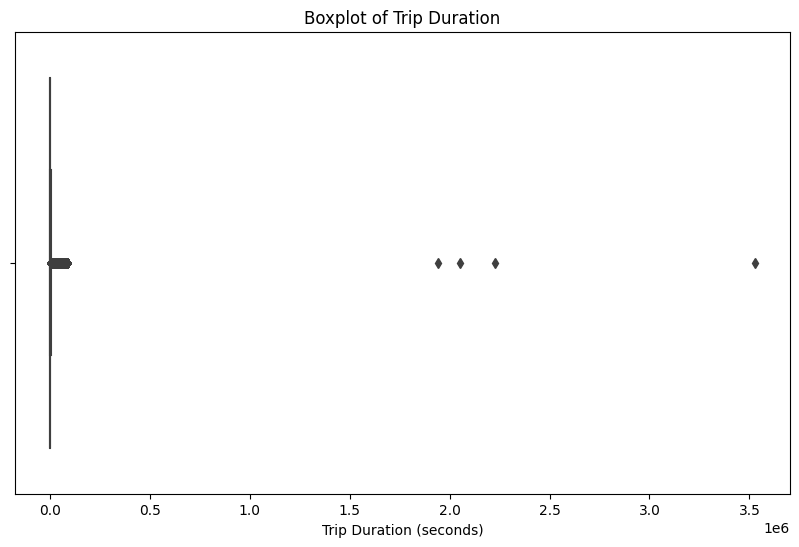


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



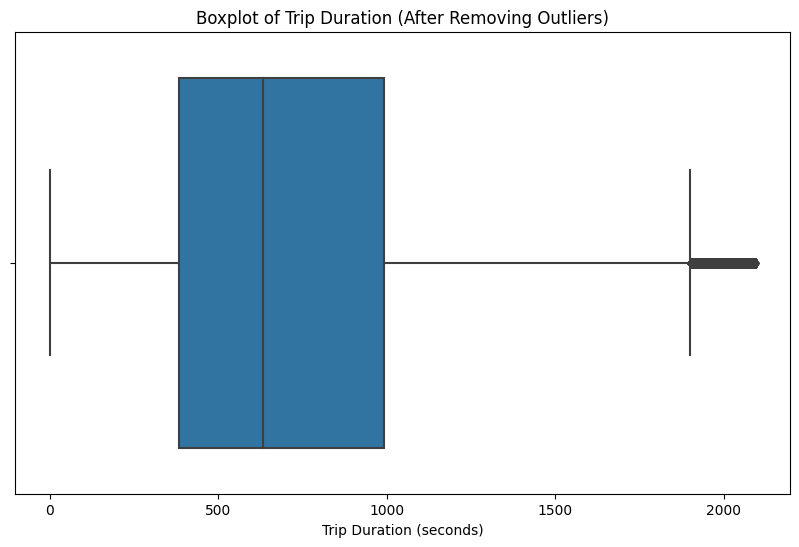

In [100]:
# using cpu
# plot boxplot for trip duration to identify outliers
# Plot boxplot for trip duration
start_time_cpu = time.time()

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = train_cpu['trip_duration'].quantile(0.25)
Q3 = train_cpu['trip_duration'].quantile(0.75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_cpu[(train_cpu['trip_duration'] < lower_bound) | (train_cpu['trip_duration'] > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_cpu = train_cpu[(train_cpu['trip_duration'] >= lower_bound) & (train_cpu['trip_duration'] <= upper_bound)]

# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_cpu = time.time()

In [101]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  0.7884955406188965
Time taken for outlier analysis using GUP:  0.7137784957885742


In [102]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Trip Duration', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Trip Duration', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# Outlier Analysis for the pickup latitude and longitude columns


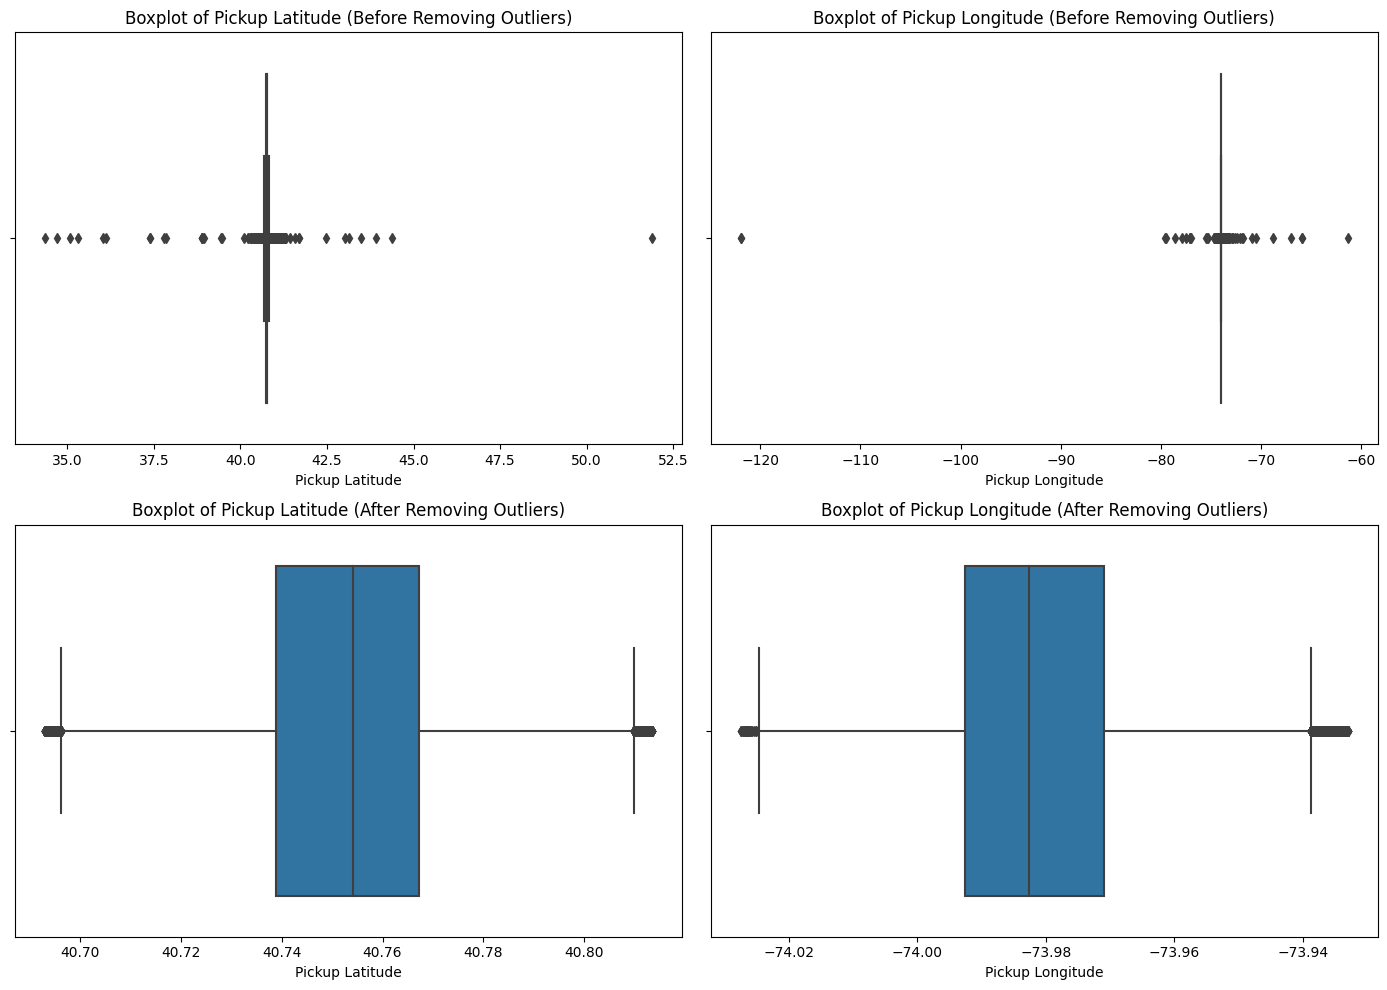

In [103]:
start_time_gpu = time.time()

# Convert the 'pickup_latitude' and 'pickup_longitude' columns of the existing 'train_gpu' DataFrame to CuPy arrays
pickup_latitude_gpu = cp.array(train_gpu['pickup_latitude'])
pickup_longitude_gpu = cp.array(train_gpu['pickup_longitude'])

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

# Plot boxplot for pickup latitude before removing outliers
plt.subplot(2, 2, 1)
sns.boxplot(x=pickup_latitude_gpu.get())  
plt.title('Boxplot of Pickup Latitude (Before Removing Outliers)')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude before removing outliers
plt.subplot(2, 2, 2)
sns.boxplot(x=pickup_longitude_gpu.get()) 
plt.title('Boxplot of Pickup Longitude (Before Removing Outliers)')
plt.xlabel('Pickup Longitude')

# Calculate the interquartile range (IQR) for pickup latitude and longitude
Q1_lat, Q3_lat = cp.percentile(pickup_latitude_gpu, [25, 75])
Q1_lon, Q3_lon = cp.percentile(pickup_longitude_gpu, [25, 75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for pickup latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_gpu = train_gpu[(train_gpu['pickup_latitude'] >= lower_bound_lat.get()) & (train_gpu['pickup_latitude'] <= upper_bound_lat.get())]
train_gpu = train_gpu[(train_gpu['pickup_longitude'] >= lower_bound_lon.get()) & (train_gpu['pickup_longitude'] <= upper_bound_lon.get())]

# Convert the 'pickup_latitude' and 'pickup_longitude' columns of the modified 'train_gpu' DataFrame to CuPy arrays
pickup_latitude_gpu2 = cp.array(train_gpu['pickup_latitude'])
pickup_longitude_gpu2 = cp.array(train_gpu['pickup_longitude'])

# Plot boxplot for pickup latitude after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=pickup_latitude_gpu2.get())  
plt.title('Boxplot of Pickup Latitude (After Removing Outliers)')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=pickup_longitude_gpu2.get()) 
plt.title('Boxplot of Pickup Longitude (After Removing Outliers)')
plt.xlabel('Pickup Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_gpu = time.time()

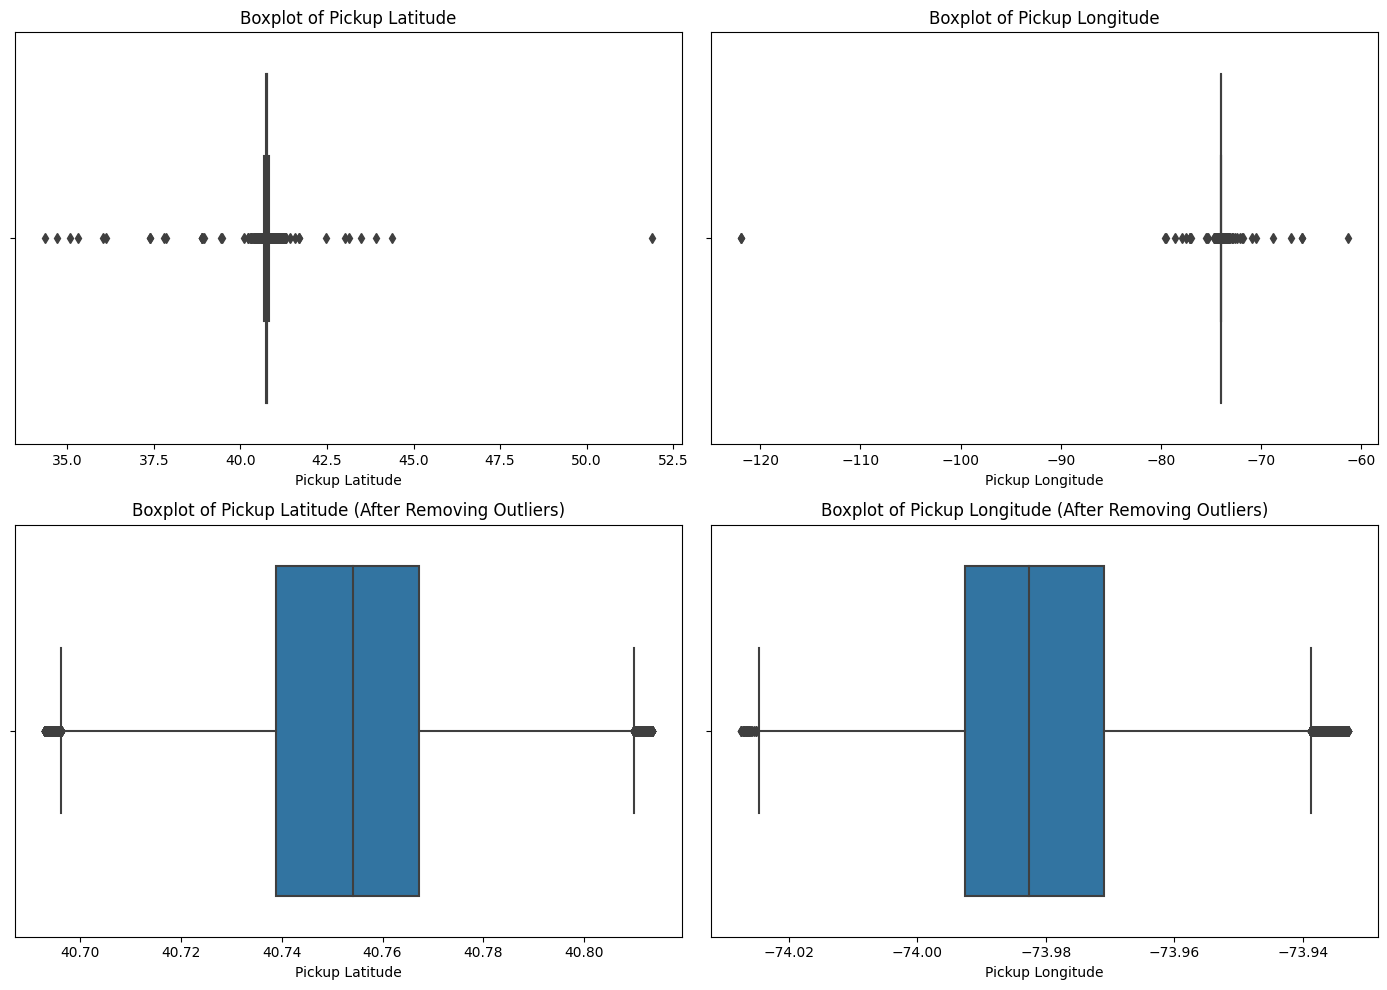

In [104]:
# Using pandas
# plot boxplot for pickup latitude and longitude to identify outliers
# Plot boxplot for pickup latitude

start_time_cpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=train_cpu['pickup_latitude'])
plt.title('Boxplot of Pickup Latitude')
plt.xlabel('Pickup Latitude')

# Plot boxplot for pickup longitude
plt.subplot(2, 2, 2)
sns.boxplot(x=train_cpu['pickup_longitude'])
plt.title('Boxplot of Pickup Longitude')
plt.xlabel('Pickup Longitude')

# Calculate the interquartile range (IQR) for pickup latitude and longitude
Q1_lat, Q3_lat = train_cpu['pickup_latitude'].quantile([0.25, 0.75])
Q1_lon, Q3_lon = train_cpu['pickup_longitude'].quantile([0.25, 0.75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for pickup latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_cpu = train_cpu[(train_cpu['pickup_latitude'] >= lower_bound_lat) & (train_cpu['pickup_latitude'] <= upper_bound_lat)]
train_cpu = train_cpu[(train_cpu['pickup_longitude'] >= lower_bound_lon) & (train_cpu['pickup_longitude'] <= upper_bound_lon)]

# boxplot after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=train_cpu['pickup_latitude'])
plt.title('Boxplot of Pickup Latitude (After Removing Outliers)')
plt.xlabel('Pickup Latitude')

# boxplot after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=train_cpu['pickup_longitude'])
plt.title('Boxplot of Pickup Longitude (After Removing Outliers)')
plt.xlabel('Pickup Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_cpu = time.time()

In [105]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  1.223386526107788
Time taken for outlier analysis using GUP:  0.9770760536193848


In [106]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Pickup Latitude and Longitude', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Pickup Latitude and Longitude', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# outlier analysis for dropoff latitude and longitude columns


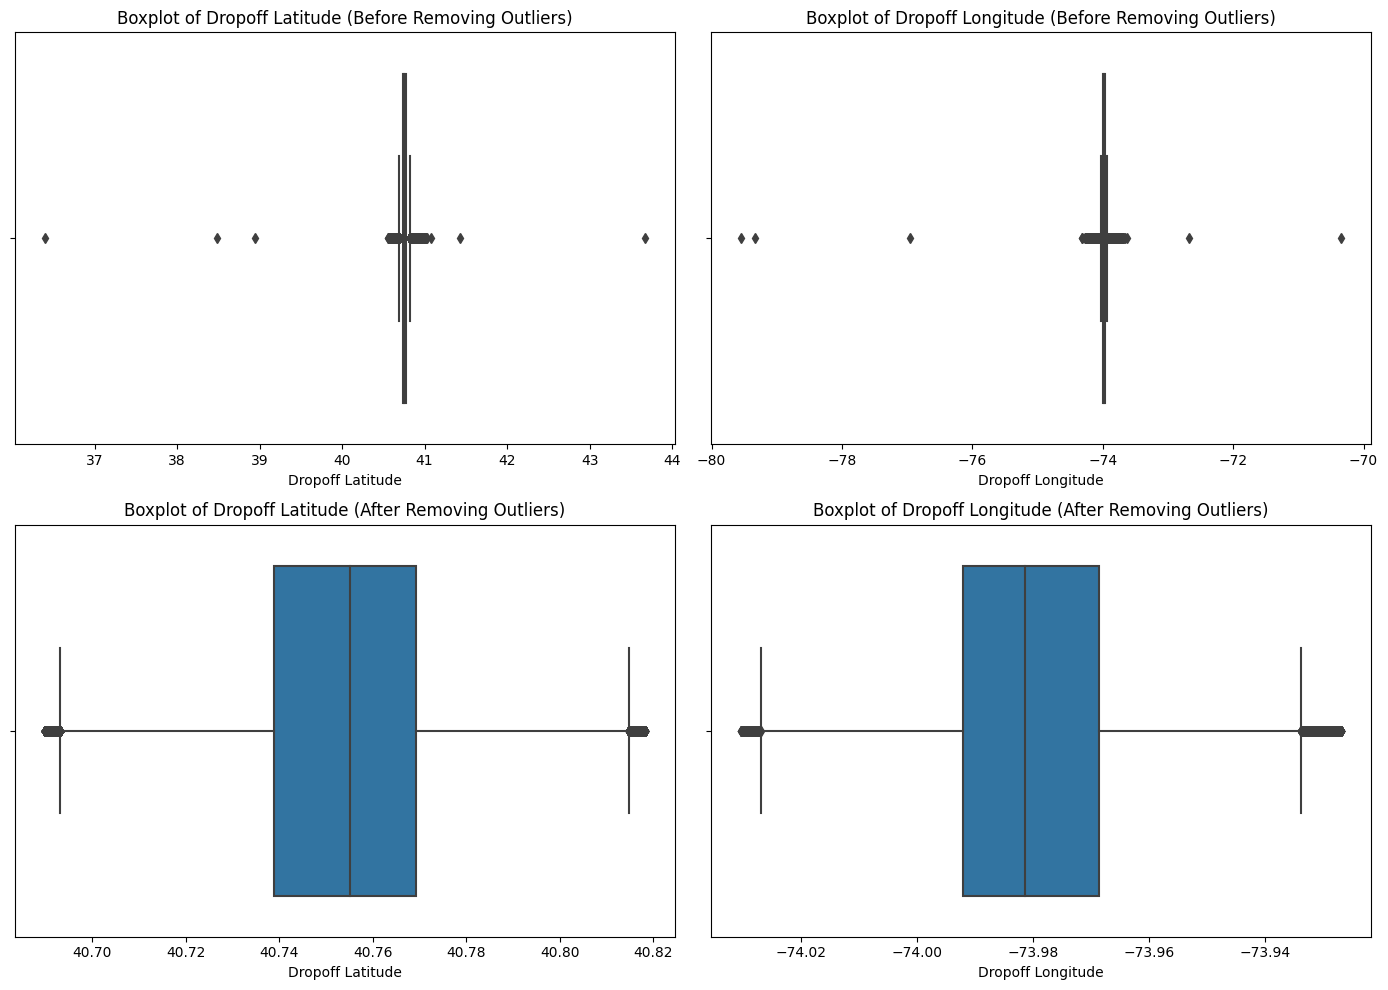

In [107]:
# Using CuPy for GPU acceleration
start_time_gpu = time.time()

# Convert the 'dropoff_latitude' and 'dropoff_longitude' columns of the existing 'train_gpu' DataFrame to CuPy arrays
dropoff_latitude_gpu = cp.array(train_gpu['dropoff_latitude'])
dropoff_longitude_gpu = cp.array(train_gpu['dropoff_longitude'])

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

# Plot boxplot for dropoff latitude before removing outliers
plt.subplot(2, 2, 1)
sns.boxplot(x=dropoff_latitude_gpu.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Latitude (Before Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# Plot boxplot for dropoff longitude before removing outliers
plt.subplot(2, 2, 2)
sns.boxplot(x=dropoff_longitude_gpu.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Longitude (Before Removing Outliers)')
plt.xlabel('Dropoff Longitude')

# Calculate the interquartile range (IQR) for dropoff latitude and longitude
Q1_lat, Q3_lat = cp.percentile(dropoff_latitude_gpu, [25, 75])
Q1_lon, Q3_lon = cp.percentile(dropoff_longitude_gpu, [25, 75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for dropoff latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

train_gpu = train_gpu[(train_gpu['dropoff_latitude'] >= lower_bound_lat.get()) & (train_gpu['dropoff_latitude'] <= upper_bound_lat.get())]

train_gpu = train_gpu[(train_gpu['dropoff_longitude'] >= lower_bound_lon.get()) & (train_gpu['dropoff_longitude'] <= upper_bound_lon.get())]

# Convert the 'dropoff_latitude' and 'dropoff_longitude' columns of the modified 'train_gpu' DataFrame to CuPy arrays
dropoff_latitude_gpu2 = cp.array(train_gpu['dropoff_latitude'])

dropoff_longitude_gpu2 = cp.array(train_gpu['dropoff_longitude'])

# Plot boxplot for dropoff latitude after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=dropoff_latitude_gpu2.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Latitude (After Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# Plot boxplot for dropoff longitude after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=dropoff_longitude_gpu2.get())  # No need to convert to NumPy explicitly
plt.title('Boxplot of Dropoff Longitude (After Removing Outliers)')
plt.xlabel('Dropoff Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_gpu = time.time()

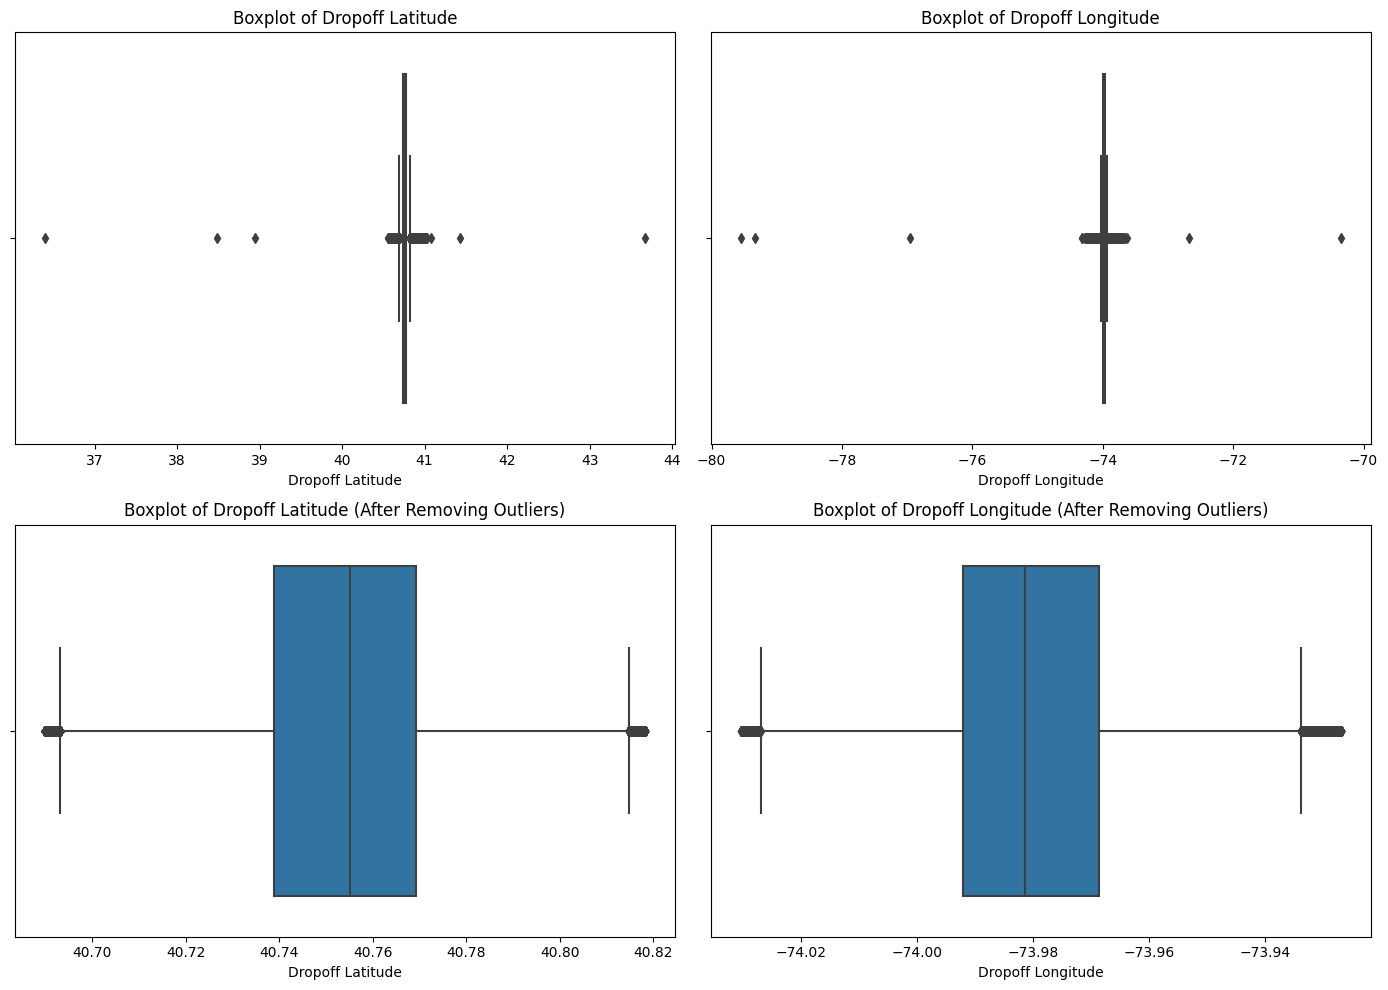

In [108]:
# Using pandas
# plot boxplot for dropoff latitude and longitude to identify outliers
# Plot boxplot for dropoff latitude
start_time_cpu = time.time()

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=train_cpu['dropoff_latitude'])
plt.title('Boxplot of Dropoff Latitude')
plt.xlabel('Dropoff Latitude')


# Plot boxplot for dropoff longitude
plt.subplot(2, 2, 2)
sns.boxplot(x=train_cpu['dropoff_longitude'])
plt.title('Boxplot of Dropoff Longitude')
plt.xlabel('Dropoff Longitude')

# Calculate the interquartile range (IQR) for dropoff latitude and longitude
Q1_lat, Q3_lat = train_cpu['dropoff_latitude'].quantile([0.25, 0.75])
Q1_lon, Q3_lon = train_cpu['dropoff_longitude'].quantile([0.25, 0.75])

IQR_lat = Q3_lat - Q1_lat
IQR_lon = Q3_lon - Q1_lon

# Calculate the lower and upper bounds for dropoff latitude and longitude
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Remove outliers
train_cpu =  train_cpu[(train_cpu['dropoff_latitude'] >= lower_bound_lat) & (train_cpu['dropoff_latitude'] <= upper_bound_lat)]
train_cpu =  train_cpu[(train_cpu['dropoff_longitude'] >= lower_bound_lon) & (train_cpu['dropoff_longitude'] <= upper_bound_lon)]

# boxplot after removing outliers
plt.subplot(2, 2, 3)
sns.boxplot(x=train_cpu['dropoff_latitude'])
plt.title('Boxplot of Dropoff Latitude (After Removing Outliers)')
plt.xlabel('Dropoff Latitude')

# boxplot after removing outliers
plt.subplot(2, 2, 4)
sns.boxplot(x=train_cpu['dropoff_longitude'])
plt.title('Boxplot of Dropoff Longitude (After Removing Outliers)')
plt.xlabel('Dropoff Longitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_cpu = time.time()

In [109]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  1.101383924484253
Time taken for outlier analysis using GUP:  0.990455150604248


In [110]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis Dropoff Latitude and Longitude', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis Dropoff Latitude and Longitude', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib) and GPU-accelerated tools, noting any differences in performance and responsiveness.


In [111]:
data_pandas = train_gpu.to_pandas()
trip_duration_pandas = train_gpu['trip_duration'].to_pandas()

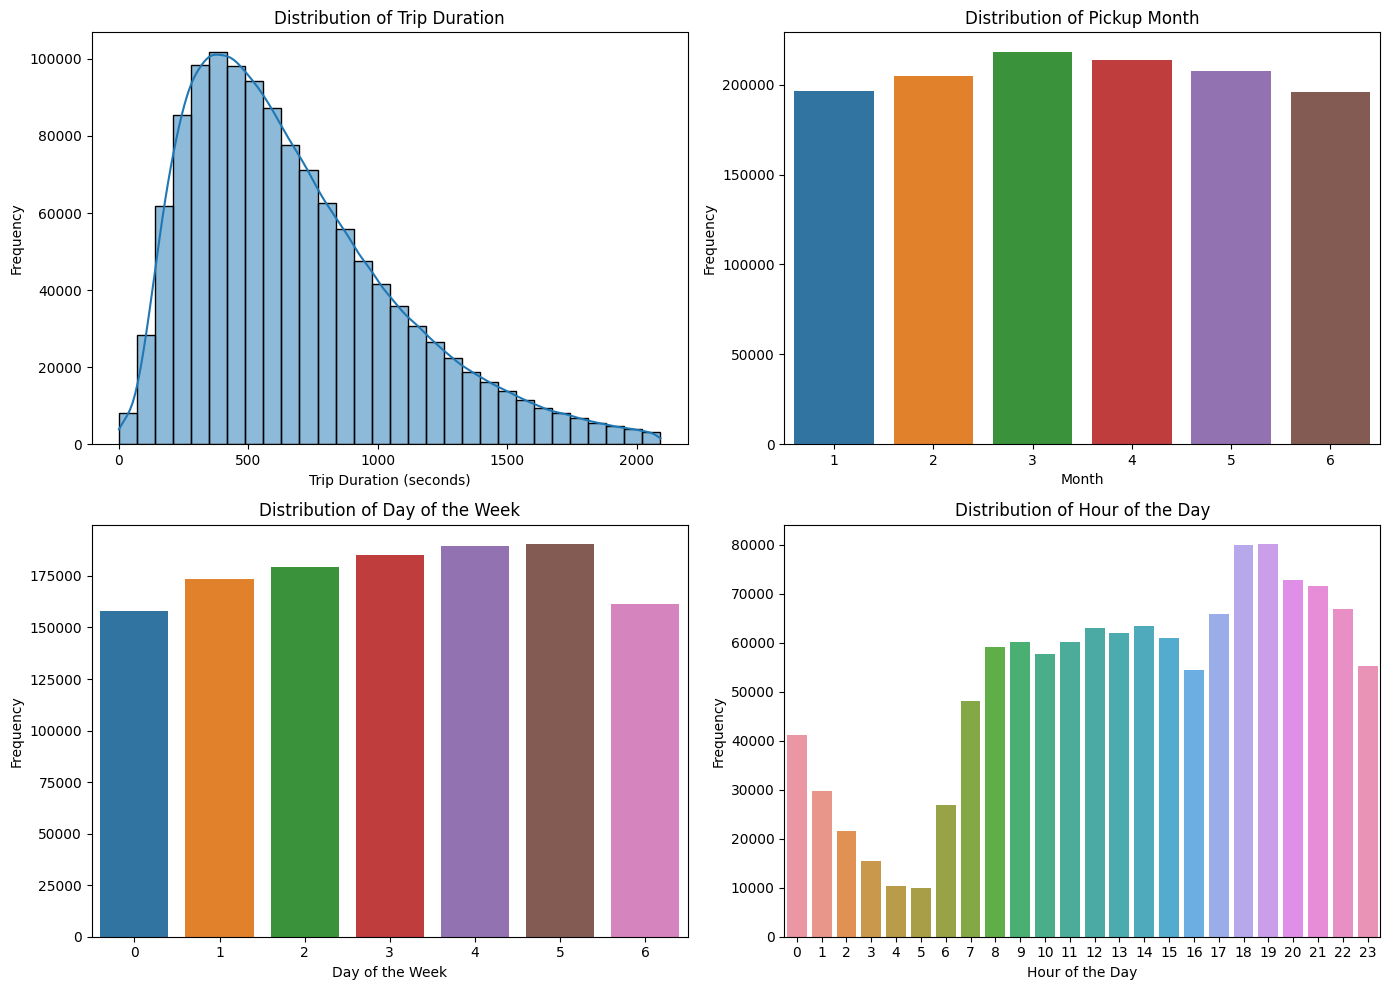

In [112]:
# EDA using GPU
# use seaborn to plot the distribution of the trip duration

start_time_gpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(trip_duration_pandas, bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')

# plot the distribution of the pickup month
plt.subplot(2, 2, 2)
sns.countplot(x='pickup_month', data=data_pandas)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

# plot the distribution of the day of the week
plt.subplot(2, 2, 3)
sns.countplot(x='pickup_day', data=data_pandas)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')

# plot the distribution of the hour of the day
plt.subplot(2, 2, 4)
sns.countplot(x='pickup_hour', data=data_pandas)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_gpu = time.time()


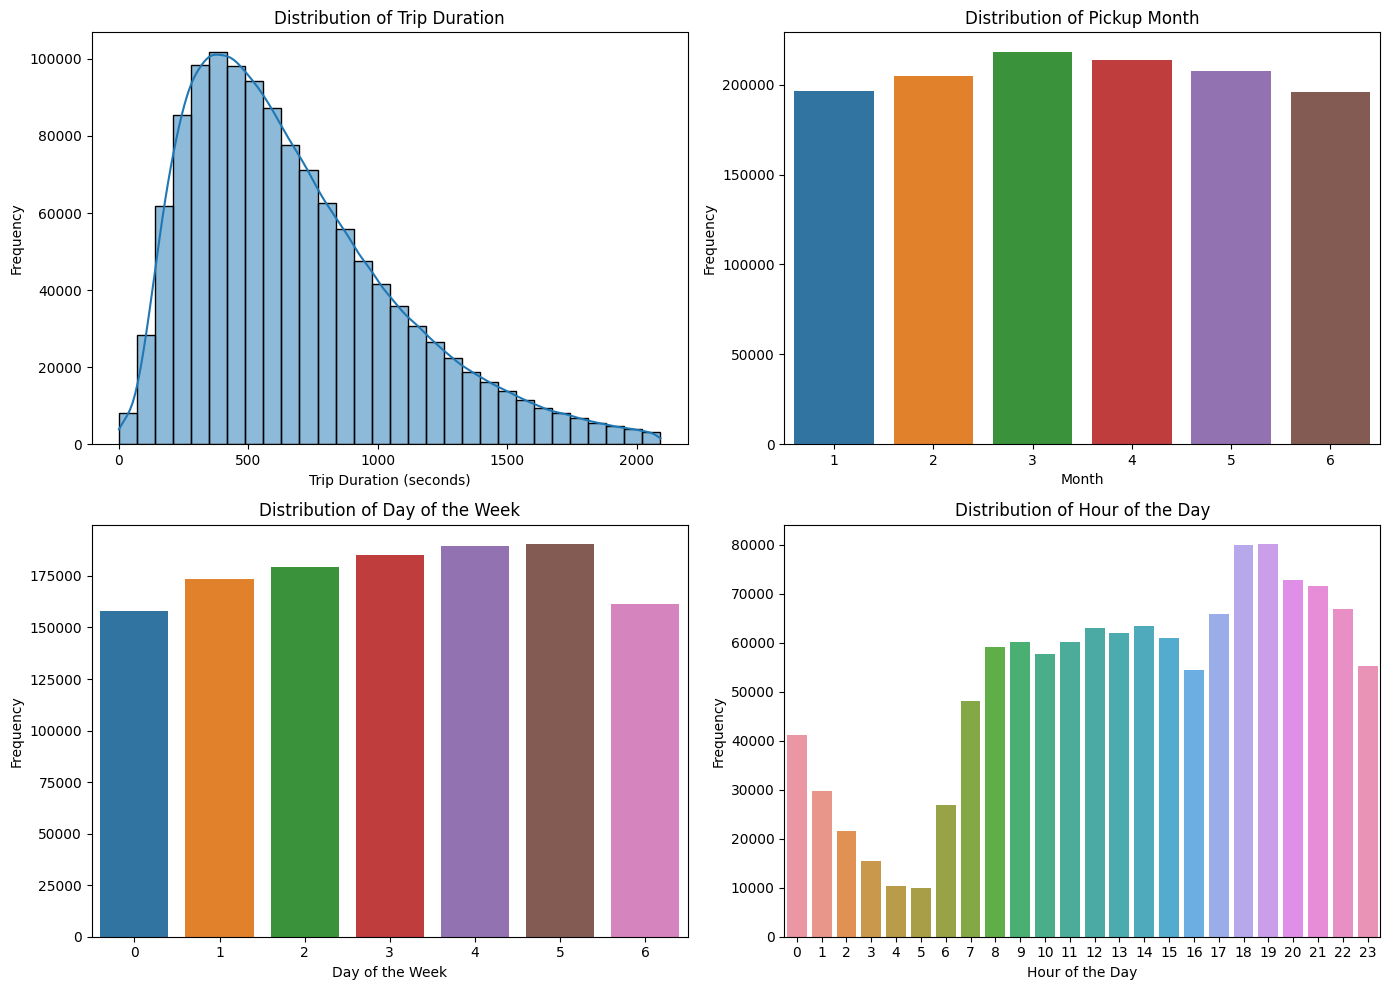

In [113]:
# use seaborn to plot the distribution of the trip duration
start_time_cpu = time.time()

# Create a 2x2 subplot grid
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_cpu['trip_duration'], bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')

# plot the distribution of the pickup month
plt.subplot(2, 2, 2)
sns.countplot(x='pickup_month', data=train_cpu)
plt.title('Distribution of Pickup Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

# plot the distribution of the day of the week
plt.subplot(2, 2, 3)
sns.countplot(x='pickup_day', data=train_cpu)
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')

# plot the distribution of the hour of the day
plt.subplot(2, 2, 4)
sns.countplot(x='pickup_hour', data=train_cpu)
plt.title('Distribution of Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

end_time_cpu = time.time()

In [114]:
# Display the time taken for EDA using pandas
print("Time taken for EDA using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for EDA using cuDF
print("Time taken for EDA using GUP: ", end_time_gpu - start_time_gpu)

Time taken for EDA using pandas:  6.620795965194702
Time taken for EDA using GUP:  6.565027952194214


In [115]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['EDA', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['EDA', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

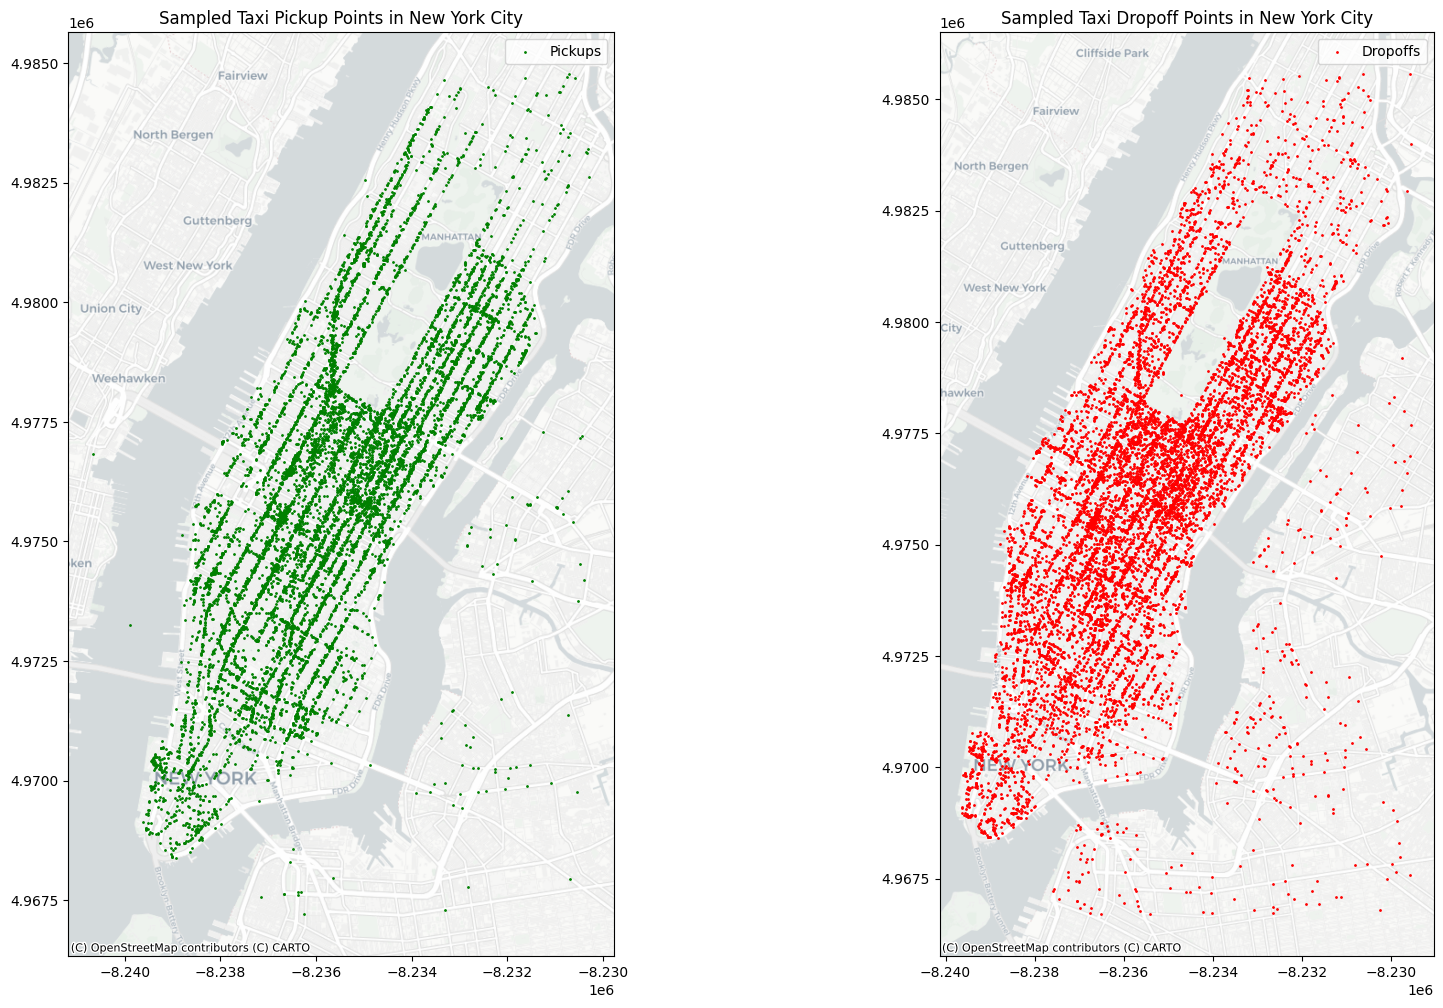

In [116]:
# Using GPU
start_time_gpu = time.time()

geometry_pickup = gpd.points_from_xy(cp.array(train_gpu['pickup_longitude']).get(), cp.array(train_gpu['pickup_latitude']).get())
geometry_dropoff = gpd.points_from_xy(cp.array(train_gpu['dropoff_longitude']).get(), cp.array(train_gpu['dropoff_latitude']).get())

# Define the coordinate system to WGS84 (EPSG:4326)
crs = {'init': 'epsg:4326'}

# Create GeoDataFrames
gdf_pickup = gpd.GeoDataFrame(train_cpu, crs=crs, geometry=geometry_pickup)
gdf_dropoff = gpd.GeoDataFrame(train_cpu, crs=crs, geometry=geometry_dropoff)

# Convert the GeoDataFrames to Web Mercator projection (EPSG:3857) for contextily
gdf_pickup = gdf_pickup.to_crs(epsg=3857)
gdf_dropoff = gdf_dropoff.to_crs(epsg=3857)

# Sample a subset of points
sampled_pickup = gdf_pickup.sample(n=10000)  
sampled_dropoff = gdf_dropoff.sample(n=10000)

# Plot the sampled points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Plot pickups
sampled_pickup.plot(ax=ax1, color='green', markersize=1, label='Pickups')
ax1.set_title('Sampled Taxi Pickup Points in New York City')
ax1.legend()
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)

# Plot dropoffs
sampled_dropoff.plot(ax=ax2, color='red', markersize=1, label='Dropoffs')
ax2.set_title('Sampled Taxi Dropoff Points in New York City')
ax2.legend()
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)

plt.show()
end_time_gpu = time.time()

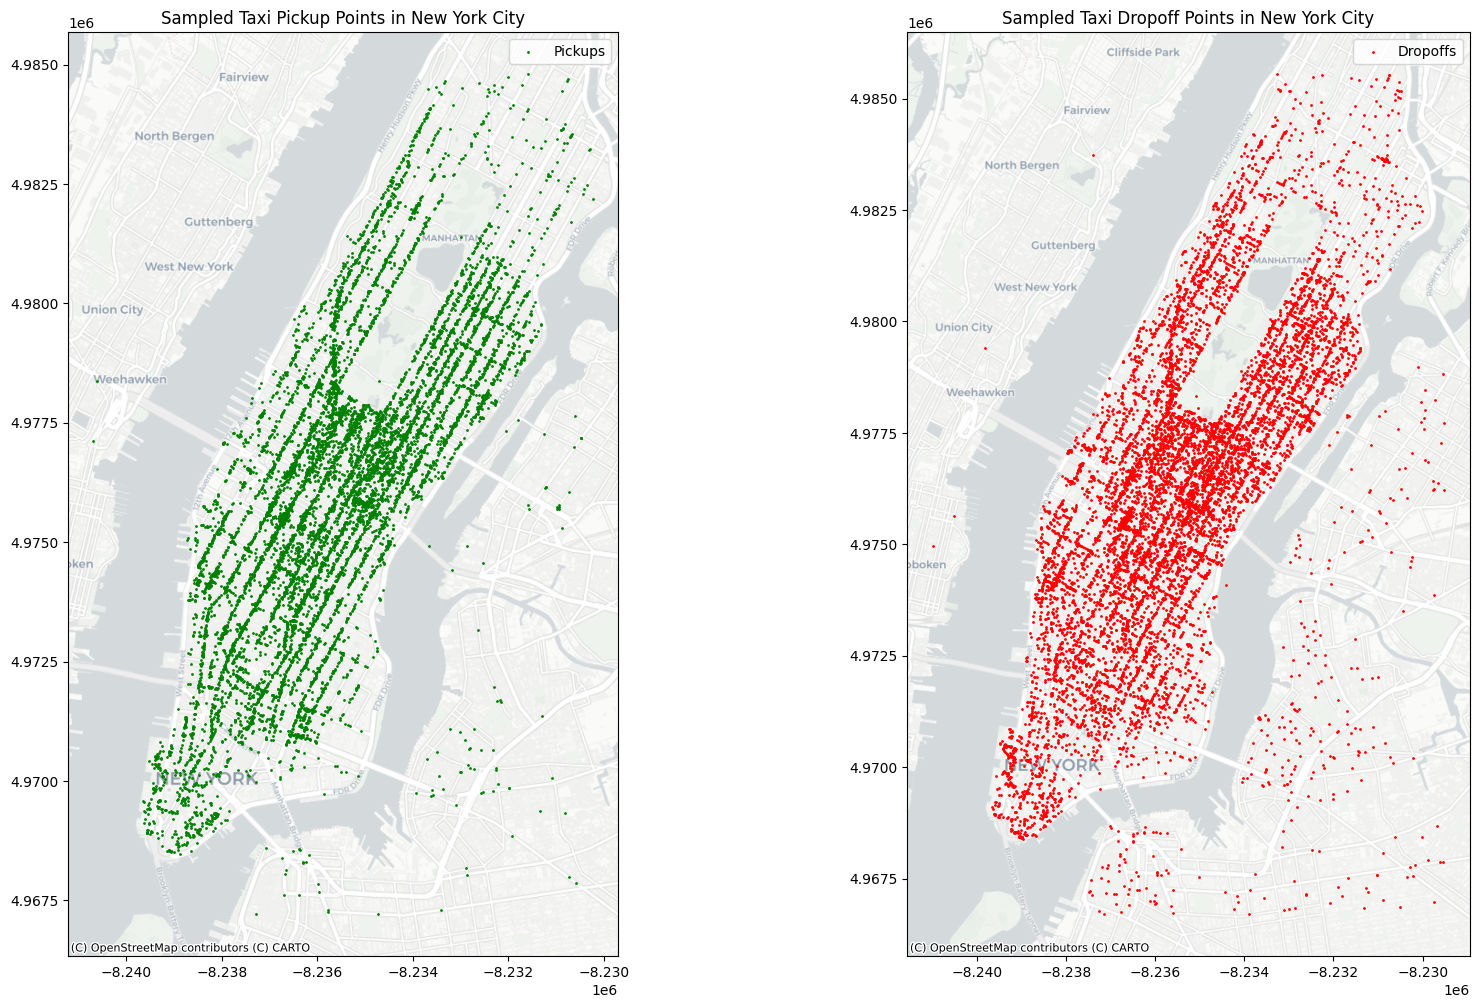

In [117]:
# Using CPU
start_time_cpu = time.time()

# Convert the DataFrame to a GeoDataFrame
geometry_pickup = gpd.points_from_xy(train_cpu.pickup_longitude, train_cpu.pickup_latitude)
geometry_dropoff = gpd.points_from_xy(train_cpu.dropoff_longitude, train_cpu.dropoff_latitude)

# Define the coordinate system to WGS84 (EPSG:4326)
crs = {'init': 'epsg:4326'}

# Create GeoDataFrames
gdf_pickup = gpd.GeoDataFrame(train_cpu, crs=crs, geometry=geometry_pickup)
gdf_dropoff = gpd.GeoDataFrame(train_cpu, crs=crs, geometry=geometry_dropoff)

# Convert the GeoDataFrames to Web Mercator projection (EPSG:3857) for contextily
gdf_pickup = gdf_pickup.to_crs(epsg=3857)
gdf_dropoff = gdf_dropoff.to_crs(epsg=3857)

# Sample a subset of points
sampled_pickup = gdf_pickup.sample(n=10000)  
sampled_dropoff = gdf_dropoff.sample(n=10000)

# Plot the sampled points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Plot pickups
sampled_pickup.plot(ax=ax1, color='green', markersize=1, label='Pickups')
ax1.set_title('Sampled Taxi Pickup Points in New York City')
ax1.legend()
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)

# Plot dropoffs
sampled_dropoff.plot(ax=ax2, color='red', markersize=1, label='Dropoffs')
ax2.set_title('Sampled Taxi Dropoff Points in New York City')
ax2.legend()
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)

plt.show()

end_time_cpu = time.time()

In [118]:
# Display the time taken for EDA using pandas
print("Time taken for map plot using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for EDA using cuDF
print("Time taken for map plot using GUP: ", end_time_gpu - start_time_gpu)

Time taken for map plot using pandas:  226.06369495391846
Time taken for map plot using GUP:  225.0593400001526


In [119]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Map Plot', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Map Plot', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# 2. Feature Engineering and Selection


# (a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.


In [120]:
# Calculate the haversine distance between pickup and dropoff coordinates
def calculate_distance(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    return hs.haversine(pickup_coords, dropoff_coords, unit=Unit.KILOMETERS)

def calculate_direction(row):
    return ox.bearing.calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])

In [121]:
training_gpu_pandas = train_gpu.to_pandas()
test_gpu_pandas = test_gpu.to_pandas()

In [122]:
# Feature Engineering using cuDF
# create a new column for the distance of the trip
# create a new column for the distance and direction of the trip
time_start_gpu = time.time()

train_gpu['distance'] = training_gpu_pandas.apply(calculate_distance, axis=1)
test_gpu['distance'] = test_gpu_pandas.apply(calculate_distance, axis=1)

train_gpu['direction'] = training_gpu_pandas.apply(calculate_direction, axis=1)
test_gpu['direction'] = test_gpu_pandas.apply(calculate_direction, axis=1)

end_time_gpu = time.time()

In [123]:
# Feature Engineering using pandas 
# create a new column for the distance of the trip

time_start_cpu = time.time()

train_cpu['distance'] = train_cpu.apply(calculate_distance, axis=1)
test_cpu['distance'] = test_cpu.apply(calculate_distance, axis=1)

train_cpu['direction'] = train_cpu.apply(calculate_direction, axis=1)
test_cpu['direction'] = test_cpu.apply(calculate_direction, axis=1)

end_time_cpu = time.time()

In [124]:
# Display the time taken for feature engineering using pandas
print("Time taken for feature engineering using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature engineering using cuDF
print("Time taken for feature engineering using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature engineering using pandas:  136.179536819458
Time taken for feature engineering using GUP:  136.54736590385437


In [125]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Engineering', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Engineering', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [126]:
train_gpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   
5          2                6        -73.982857        40.742195   

   dropoff_longitude  dropoff_latitude  pickup_month  pickup_day  pickup_hour  \
0         -73.964630         40.765602             3           0           17   
1         -73.999481         40.731152             6           6            0   
3         -74.012268         40.706718             4           2           19   
4         -73.972923         40.782520             3           5           13   
5         -73.992081         40.749184             1           5           22   

   trip_duration  distance   direction  
0            455  1.498523   99.970196  
1            663  1.805510  242.846232  
3            429  1.485500  187.262300  
4            435  1.188590  179.473585  
5            443  1.098944  315.004404

In [127]:
test_gpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  pickup_month  \
0         -73.990173         40.756680                  N             6   
1         -73.959808         40.655403                  N             6   
2         -73.986160         40.729523                  N             6   
3         -73.986427         40.730469                  N             6   
4         -73.961510         40.755890                  N             6   

   pickup_day  pickup_hour  distance   direction  
0           3           23  2.746430  356.404776  
1           3           23  2.759243  172.278835  
2           3           23  1.306157  133.326248  
3           3           23  5.269095  209.043167  
4           3           23  0.960843  130.260381

In [128]:
train_cpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   
5          2                6        -73.982857        40.742195   

   dropoff_longitude  dropoff_latitude  pickup_month  pickup_day  pickup_hour  \
0         -73.964630         40.765602             3           0           17   
1         -73.999481         40.731152             6           6            0   
3         -74.012268         40.706718             4           2           19   
4         -73.972923         40.782520             3           5           13   
5         -73.992081         40.749184             1           5           22   

   trip_duration  distance   direction  
0            455  1.498523   99.970196  
1            663  1.805510  242.846232  
3            429  1.485500  187.262300  
4            435  1.188590  179.473585  
5            443  1.098944  315.004404

In [129]:
test_cpu.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  pickup_month  \
0         -73.990173         40.756680                  N             6   
1         -73.959808         40.655403                  N             6   
2         -73.986160         40.729523                  N             6   
3         -73.986427         40.730469                  N             6   
4         -73.961510         40.755890                  N             6   

   pickup_day  pickup_hour  distance   direction  
0           3           23  2.746430  356.404776  
1           3           23  2.759243  172.278835  
2           3           23  1.306157  133.326248  
3           3           23  5.269095  209.043167  
4           3           23  0.960843  130.260381

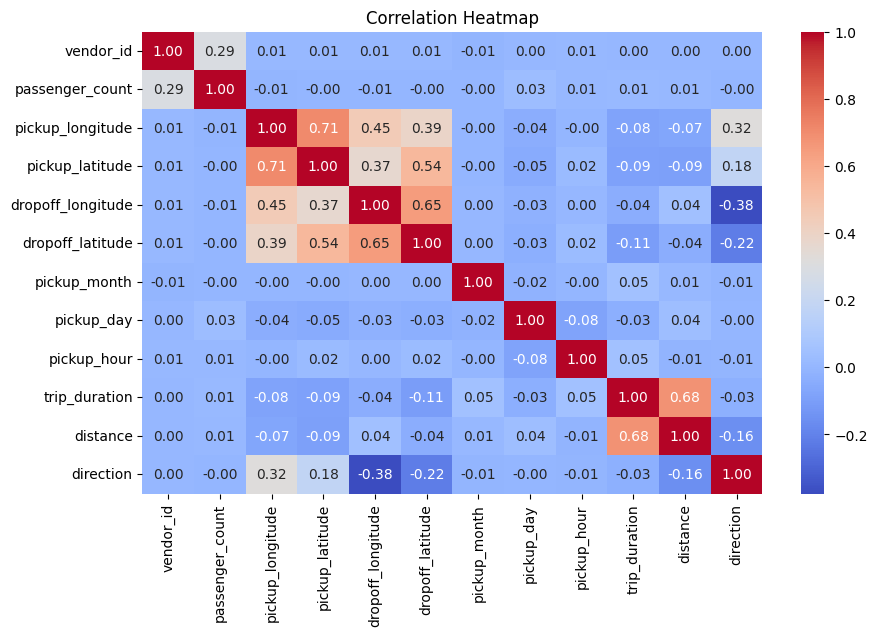

In [130]:
# Feature Selection using cuDF
# calculate the correlation between the features and the target variable trip_duration
time_start_gpu = time.time()

correlation_gpu = train_gpu.to_pandas().corr()['trip_duration']
# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_gpu.to_pandas().corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

end_time_gpu = time.time()

In [131]:
correlation_gpu

vendor_id            0.001414
passenger_count      0.011924
pickup_longitude    -0.083585
pickup_latitude     -0.086984
dropoff_longitude   -0.040261
dropoff_latitude    -0.105856
pickup_month         0.049384
pickup_day          -0.032737
pickup_hour          0.048193
trip_duration        1.000000
distance             0.681994
direction           -0.027193
Name: trip_duration, dtype: float64

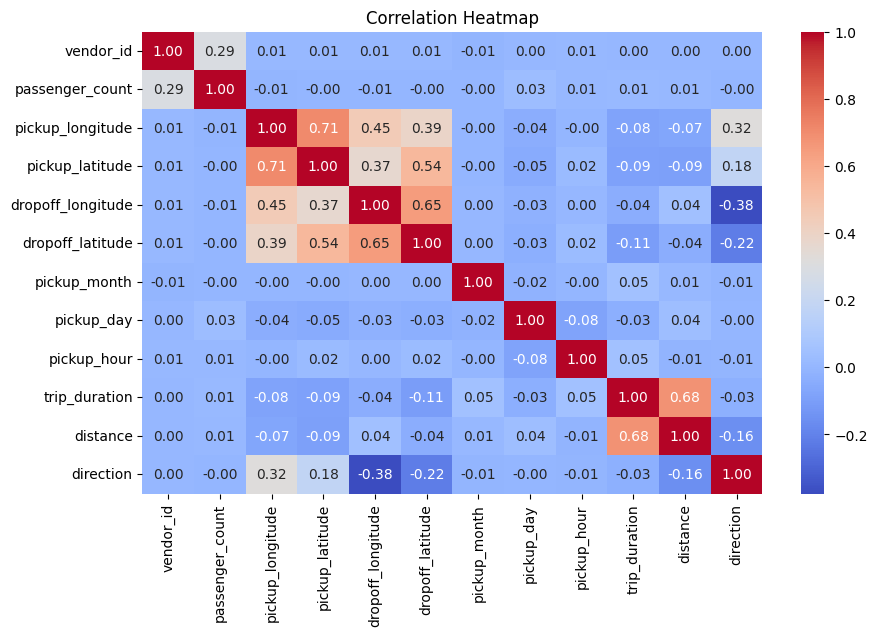

In [132]:
# Feature Selection using pandas
# calculate the correlation between the features and the target variable trip_duration
time_start_cpu = time.time()

correlation_cpu = train_cpu.corr()['trip_duration']

# print corelation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_cpu.corr(), annot=True, cmap='coolwarm', fmt=".2f")   
plt.title('Correlation Heatmap')
plt.show()

end_time_cpu = time.time()

In [133]:
correlation_cpu

vendor_id            0.001414
passenger_count      0.011924
pickup_longitude    -0.083585
pickup_latitude     -0.086984
dropoff_longitude   -0.040261
dropoff_latitude    -0.105856
pickup_month         0.049384
pickup_day          -0.032737
pickup_hour          0.048193
trip_duration        1.000000
distance             0.681994
direction           -0.027193
Name: trip_duration, dtype: float64

The choosen features based on the correlation values are:
- distance
- dropoff_longitude
- dropoff_latitude
- pickup_longitude
- pickup_latitude
- pickup_hour   
- pickup_month
- pickup_day

In [134]:
# Display the time taken for Correlation Analysis using pandas
print("Time taken for Correlation Analysis using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for Correlation Analysis using cuDF
print("Time taken for Correlation Analysis using GUP: ", end_time_gpu - time_start_gpu)

Time taken for Correlation Analysis using pandas:  1.8001794815063477
Time taken for Correlation Analysis using GUP:  1.898864507675171


In [135]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Correlation Analysis', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Correlation Analysis', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [136]:
# create a new dataframe with only the selected features for both the training and test sets using cuDF
time_start_gpu = time.time()

train_gpu_feature = train_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_gpu_feature = test_gpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_gpu = time.time()

In [137]:
# create a new dataframe with only the selected features for both the training and test sets using pandas

time_start_cpu = time.time()

train_cpu_feature = train_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day', 'trip_duration']]
test_cpu_feature = test_cpu[['distance', 'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_month', 'pickup_day']]

end_time_cpu = time.time()

In [138]:
# Display the time taken for feature selection using pandas
print("Time taken for feature selection using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for feature selection using cuDF
print("Time taken for feature selection using GUP: ", end_time_gpu - time_start_gpu)

Time taken for feature selection using pandas:  0.09872150421142578
Time taken for feature selection using GUP:  0.0015599727630615234


In [139]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Feature Selection', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Feature Selection', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [140]:
cpu_metrics

Task    start_time  \
0                                     Data Loading  1.713716e+09   
1                               Data Preprocessing  1.713716e+09   
2                   Outlier Analysis Trip Duration  1.713716e+09   
3   Outlier Analysis Pickup Latitude and Longitude  1.713716e+09   
4  Outlier Analysis Dropoff Latitude and Longitude  1.713716e+09   
5                                              EDA  1.713716e+09   
6                                         Map Plot  1.713716e+09   
7                              Feature Engineering  1.713717e+09   
8                             Correlation Analysis  1.713717e+09   
9                                Feature Selection  1.713717e+09   

       end_time  time_taken  
0  1.713716e+09    5.761560  
1  1.713716e+09    4.507149  
2  1.713716e+09    0.788496  
3  1.713716e+09    1.223387  
4  1.713716e+09    1.101384  
5  1.713716e+09    6.620796  
6  1.713717e+09  226.063695  
7  1.713717e+09  136.179537  
8  1.713717e+09    1.800179  
9  1.713717e+09    0.098722

In [141]:
gpu_metrics

Task    start_time  \
0                                     Data Loading  1.713716e+09   
1                               Data Preprocessing  1.713716e+09   
2                   Outlier Analysis Trip Duration  1.713716e+09   
3   Outlier Analysis Pickup Latitude and Longitude  1.713716e+09   
4  Outlier Analysis Dropoff Latitude and Longitude  1.713716e+09   
5                                              EDA  1.713716e+09   
6                                         Map Plot  1.713716e+09   
7                              Feature Engineering  1.713717e+09   
8                             Correlation Analysis  1.713717e+09   
9                                Feature Selection  1.713717e+09   

       end_time  time_taken  
0  1.713716e+09    0.277149  
1  1.713716e+09    0.063682  
2  1.713716e+09    0.713778  
3  1.713716e+09    0.977076  
4  1.713716e+09    0.990455  
5  1.713716e+09    6.565028  
6  1.713716e+09  225.059340  
7  1.713717e+09  136.547366  
8  1.713717e+09    1.898865  
9  1.713717e+09    0.001560

# 3. Model Training and Evaluation


# (a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU) and cuML (GPU). Record and compare the training times.


In [142]:
# Model Training using cuML

inputs_gpu = train_gpu_feature.drop('trip_duration', axis=1)
targer_gpu = train_gpu_feature['trip_duration']

X_gpu = inputs_gpu.values
y_gpu = targer_gpu.values

# Split the data into training and testing sets
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using cuML
start_time_gpu = time.time()

gbm_gpu = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_gpu.fit(X_train_gpu, y_train_gpu)
#y_pred_gpu = gbm_gpu.predict(X_train_gpu_reshaped)

end_time_gpu = time.time()

In [143]:
# Model Training using scikit-learn

inputs_cpu = train_cpu_feature.drop('trip_duration', axis=1)
targer_cpu = train_cpu_feature['trip_duration']

X_cpu = inputs_cpu.values
y_cpu = targer_cpu.values

# Split the data into training and testing sets
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X_cpu, y_cpu, test_size=0.2, random_state=42)

# Train the Gradient Boosting Machine model using scikit-learn

start_time_cpu = time.time()

gbm_cpu = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
gbm_cpu.fit(X_train_cpu, y_train_cpu)
#y_pred_cpu = gbm_cpu.predict(X_train_cpu)

end_time_cpu = time.time()

In [144]:
# Display the time taken for model training using scikit-learn
print("Time taken for model training using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model training using cuML
print("Time taken for model training using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model training using scikit-learn:  341.9042387008667
Time taken for model training using cuML:  3.083744764328003


In [145]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Training', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Training', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Evaluate the accuracy of both models and document the time taken for predictions on the test set using CPU and GPU.


In [146]:
# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# evaluate the model on the test data
predictions_gpu = gbm_gpu.predict(X_test_gpu)

# output the first 5 predictions
print('Predictions:', predictions_gpu[:5])

# Model Evaluation using xgboost
# Evaluate the model on the test set

start_time_gpu = time.time()

# Convert Cupy arrays to NumPy arrays
y_test_numpy = cp.asnumpy(y_test_gpu)
predictions_numpy = cp.asnumpy(predictions_gpu)

# Calculate the mean squared error
mean_squared_error_gpu = mean_squared_error(y_test_numpy, predictions_numpy)
print('Mean Squared Error (GPU):', mean_squared_error_gpu)

# calculate the R-squared value
r_squared_gpu = r2_score(y_test_numpy, predictions_numpy)
print('R-squared (GPU):', r_squared_gpu)

end_time_gpu = time.time()


Predictions: [ 619.48834  904.5302  1308.4122   959.99664  723.9362 ]
Mean Squared Error (GPU): 52945.87695613112
R-squared (GPU): 0.6764482646483383


In [147]:
# Model Evaluation using scikit-learn
# Evaluate the model on the test set

# evaluate the model on the test data

predictions_cpu = gbm_cpu.predict(X_test_cpu)

# output the first 5 predictions
print('Predictions:', predictions_cpu[:5])

# Model Evaluation using scikit-learn
# Evaluate the model on the test set

start_time_cpu = time.time()

# Calculate the mean squared error
mean_squared_error_cpu = mean_squared_error(y_test_cpu, predictions_cpu)
print('Mean Squared Error (CPU):', mean_squared_error_cpu)

# calculate the R-squared value
r_squared_cpu = r2_score(y_test_cpu, predictions_cpu)
print('R-squared (CPU):', r_squared_cpu)

end_time_cpu = time.time()

Predictions: [ 607.97708028  867.95642933 1302.87106023  966.51081138  725.73219264]
Mean Squared Error (CPU): 52446.37710242966
R-squared (CPU): 0.6795007033605522


In [148]:
# Display the time taken for model evaluation using scikit-learn
print("Time taken for model evaluation using scikit-learn: ", end_time_cpu - start_time_cpu)
# Display the time taken for model evaluation using cuML
print("Time taken for model evaluation using cuML: ", end_time_gpu - start_time_gpu)

Time taken for model evaluation using scikit-learn:  0.003979206085205078
Time taken for model evaluation using cuML:  0.005265235900878906


In [149]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Model Evaluation', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Model Evaluation', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [150]:
cpu_metrics

Task    start_time  \
0                                      Data Loading  1.713716e+09   
1                                Data Preprocessing  1.713716e+09   
2                    Outlier Analysis Trip Duration  1.713716e+09   
3    Outlier Analysis Pickup Latitude and Longitude  1.713716e+09   
4   Outlier Analysis Dropoff Latitude and Longitude  1.713716e+09   
5                                               EDA  1.713716e+09   
6                                          Map Plot  1.713716e+09   
7                               Feature Engineering  1.713717e+09   
8                              Correlation Analysis  1.713717e+09   
9                                 Feature Selection  1.713717e+09   
10                                   Model Training  1.713717e+09   
11                                 Model Evaluation  1.713718e+09   

        end_time  time_taken  
0   1.713716e+09    5.761560  
1   1.713716e+09    4.507149  
2   1.713716e+09    0.788496  
3   1.713716e+09    1.223387  
4   1.713716e+09    1.101384  
5   1.713716e+09    6.620796  
6   1.713717e+09  226.063695  
7   1.713717e+09  136.179537  
8   1.713717e+09    1.800179  
9   1.713717e+09    0.098722  
10  1.713718e+09  341.904239  
11  1.713718e+09    0.003979

In [151]:
gpu_metrics

Task    start_time  \
0                                      Data Loading  1.713716e+09   
1                                Data Preprocessing  1.713716e+09   
2                    Outlier Analysis Trip Duration  1.713716e+09   
3    Outlier Analysis Pickup Latitude and Longitude  1.713716e+09   
4   Outlier Analysis Dropoff Latitude and Longitude  1.713716e+09   
5                                               EDA  1.713716e+09   
6                                          Map Plot  1.713716e+09   
7                               Feature Engineering  1.713717e+09   
8                              Correlation Analysis  1.713717e+09   
9                                 Feature Selection  1.713717e+09   
10                                   Model Training  1.713717e+09   
11                                 Model Evaluation  1.713718e+09   

        end_time  time_taken  
0   1.713716e+09    0.277149  
1   1.713716e+09    0.063682  
2   1.713716e+09    0.713778  
3   1.713716e+09    0.977076  
4   1.713716e+09    0.990455  
5   1.713716e+09    6.565028  
6   1.713716e+09  225.059340  
7   1.713717e+09  136.547366  
8   1.713717e+09    1.898865  
9   1.713717e+09    0.001560  
10  1.713717e+09    3.083745  
11  1.713718e+09    0.005265